# 233 filtered Articles by inclusion/exclusion criteria
These include Surveys and Position Papers

### Include criteria
* must be a combination of neural and symbolic techniques (NOT comaparisons of same, NOT ensembles of each)
* must be text as input

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from wordcloud import WordCloud
import utils
import umap
import hdbscan
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/nuero-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/utils.py'>

In [2]:
df=pd.read_csv("scopus-filtered-by-on-topic.csv")

In [3]:
print(len(df))

233


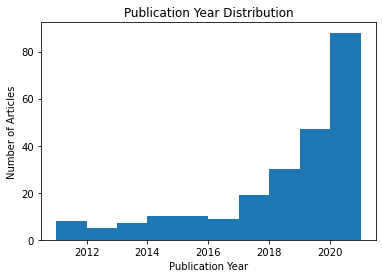

In [4]:
plt.hist(df['Publication Year'])
plt.title('Publication Year Distribution')
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.show()

In [5]:
def drawCloud(text):
    wc = WordCloud(background_color="white", 
                   max_words=350, 
                   width=1000, 
                   height=600, 
                   random_state=1).generate(text)

    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis("off")

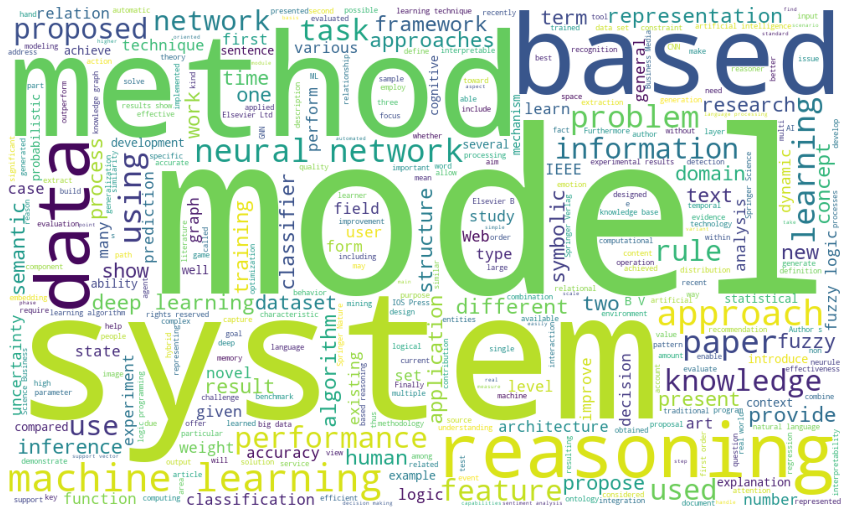

In [6]:
text = ','.join(list(df['Abstract Note']))
drawCloud(text)

## Topics
Use raw text abstracts, or load previously trained embeddings

In [9]:
abstracts = np.array(df['Abstract Note'])

In [10]:
fileName='embeddings1627816190.5488052.txt'
embeddings = np.loadtxt(fileName, delimiter=',')

In [11]:
importlib.reload(utils)
# defaults: make_clusters(data, neighbors=15, components=5, cluster_size=5, save_embeddings=False)
cluster = utils.make_clusters(embeddings,save_embeddings=False)

In [12]:
set(cluster.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Visualise clusters

In [15]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

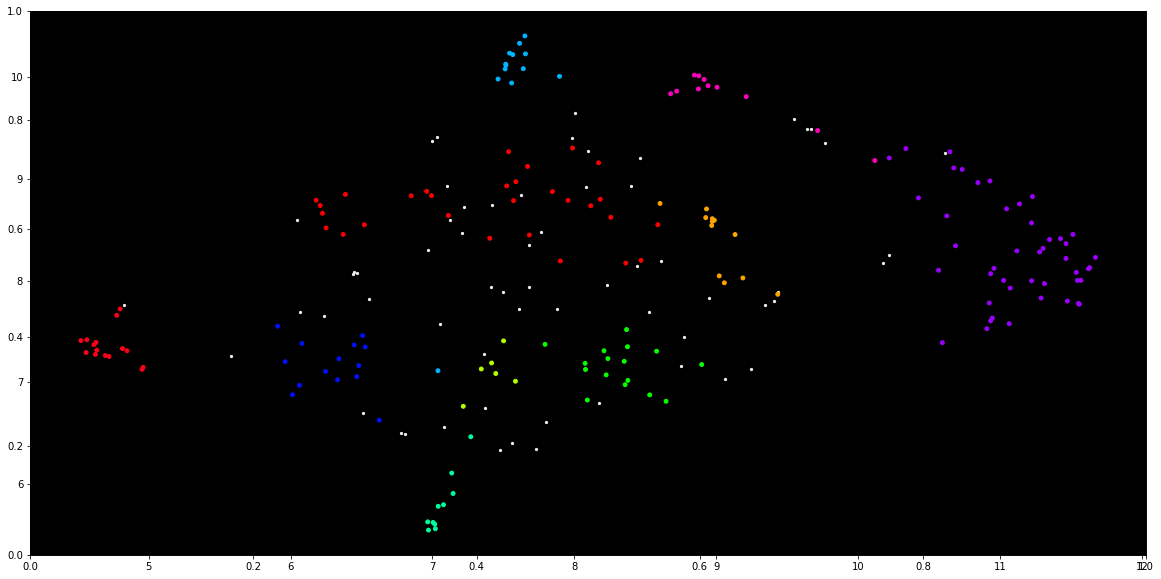

In [16]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
ax = fig.add_subplot(facecolor='#000000')
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#eeeeee', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.show()

## Topic keywords

In [17]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/nuero-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/utils.py'>

In [18]:
top_n_words, topic_sizes = utils.get_topics(cluster, abstracts)

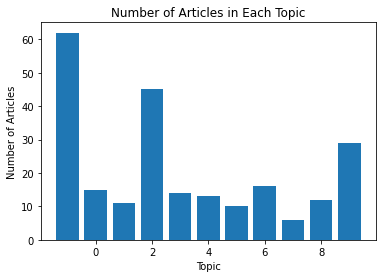

In [19]:
plt.bar(topic_sizes['Topic'],topic_sizes['Size'])
plt.title('Number of Articles in Each Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.show()

In [26]:
# -1 topic are outliers (not part of any topic)

for i in range(0,len(topic_sizes-1)):
    print("Topic: ",topic_sizes["Topic"].iloc[i], "| Size: ", topic_sizes["Size"].iloc[i])
    print("_"*50)
    for j in top_n_words[i-1][:10]:
        print(j[0])
    print("="*50)

Topic:  -1 | Size:  62
__________________________________________________
features
classification
cnn
domain
semantic
tasks
feature
learner
uses
predictions
Topic:  2 | Size:  45
__________________________________________________
sentiment
emotion
fdlc
rate
negative
analysis
social
crowd
positive
analysts
Topic:  9 | Size:  29
__________________________________________________
neurules
neurule
connectionist
oriented
rules
adaline
symbolic
rough
base
reduction
Topic:  6 | Size:  16
__________________________________________________
fuzzy
output
functions
cloud
layer
weights
quadratic
forecasting
network
neurons
Topic:  0 | Size:  15
__________________________________________________
temporal
summarization
sentences
text
relevance
document
generalization
textual
content
ir
Topic:  3 | Size:  14
__________________________________________________
cognitive
cfs
patterns
conceptual
symbolic
sub
dynamics
cognition
dynamical
architectures
Topic:  4 | Size:  13
_________________________________

# Citation network
Create a citation graph based on authors (not papers). Use it to find most "infuential" authors by performing PageRank

In [789]:
df=pd.read_csv("scopus (233).csv")

In [790]:
# df['References']

In [796]:
# we only care about authors and references for this graph.
dfc=df[['Authors','References']]

In [801]:
# authors are separated by a comma. Create a list by splitting on ,
df_auth=df[['Authors','References']]
df_auth['Authors']=df_auth['Authors'].str.split(pat=",")

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [802]:
# put each author in their own row
df_auth=df_auth.set_index(['References']).apply(pd.Series.explode).reset_index()

In [803]:
df_auth['References']=1

## Authors with most articles

In [804]:
auth_count=df_auth.groupby(['Authors']).count().reset_index()
auth_count=auth_count.sort_values(by='References', ascending=False)
auth_count=auth_count[auth_count['References']>1]
auth_count.head(10)
# plt.bar(auth_count['ref_Author'],auth_count['Authors'])

,Authors,References
453,Wang H.,5
323,Pedrycz W.,4
230,Li J.,4
483,Xu D.-L.,3
500,Yang J.-B.,3
452,Wang G.,3
245,Liu Y.,3
152,Hao Y.,3
729,Wang Q.,3
232,Li Y.,3


In [760]:
# references are separated by a semi-colon. Create a list by splitting on ;
dfc['References']=dfc['References'].str.split(pat=";")

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [761]:
# put each citation in its own row
dfc=dfc.set_index(['Authors']).apply(pd.Series.explode).reset_index()

### Get the author names from the citation
`(([À-ŽA-z|\-|\']\s?)+,?\s(\-?[À-Ž|A-Z]\.)+)\,`   
As far as I can tell, this captures the author names pretty well:
<img src="authors-regex-example.jpg">

In [762]:
# Extracts authors from the references and creates new row for each
dfc[['ref_Id','match','ref_Author']]=dfc['References'].str.extractall(pat=r"(([À-ŽA-z|\-|\']\s?)+,?\s(\-?[À-Ž|A-Z]\.)+)\,").reset_index()[['level_0','match',0]]

In [763]:
# remove redundant columns
dfc=dfc[['Authors','ref_Id','ref_Author']]

In [764]:
# authors are separated by a comma. Create a list by splitting on ,
dfc['Authors']=dfc['Authors'].str.split(pat=",")

## Authors most frequently referenced

In [766]:
ref_auth_count=dfc.groupby(['ref_Author']).count().sort_values(by='Authors', ascending=False)
ref_auth_count=ref_auth_count.reset_index()
ref_auth_count=ref_auth_count[ref_auth_count['Authors']>20]
ref_auth_count
# plt.bar(auth_count['ref_Author'],auth_count['Authors'])

,ref_Author,Authors,ref_Id
0,"Bengio, Y.",55,55
1,"De Raedt, L.",39,39
2,"Riedel, S.",35,35
3,"Socher, R.",30,30
4,"Liu, Z.",28,28
5,"Rocktäschel, T.",28,28
6,"Tenenbaum, J.B.",27,27
7,"Hitzler, P.",27,27
8,"Bordes, A.",26,26
9,"Kimmig, A.",26,26


In [767]:
# put each author in their own row
dfc=dfc.set_index(['ref_Id','ref_Author']).apply(pd.Series.explode).reset_index()

In [768]:
# now we have a cartesian-join of authors 
dfc

,ref_Id,ref_Author,Authors
0,0,"Paredes, J.N.",Paredes J.N.
1,0,"Paredes, J.N.",Simari G.I.
2,0,"Paredes, J.N.",Martinez M.V.
3,0,"Paredes, J.N.",Falappa M.A.
4,0,"Simari, G.I.",Paredes J.N.
...,...,...,...
43616,4149,"Li, J.",De La Rosa J.-L.
43617,4149,"Li, J.",Kovalerchuk B.
43618,4149,"Wang, S.",Galitsky B.
43619,4149,"Wang, S.",De La Rosa J.-L.


In [769]:
# remove commas from the ref_Author so the format matches that of Authors
dfc['ref_Author'].replace(',','', regex=True, inplace=True)

In [770]:
ref_author_nodes=dfc['ref_Author'].unique()

In [771]:
author_nodes=dfc['Authors'].unique()

In [772]:
author_nodes

array(['Paredes J.N.', ' Simari G.I.', ' Martinez M.V.', ' Falappa M.A.',
       'Wu X.', ' Weng J.', 'Cozman F.G.', ' Munhoz H.N.', 'Manhaeve R.',
       ' Dumančić S.', ' Kimmig A.', ' Demeester T.', ' De Raedt L.',
       'Mittal V.', ' Gangodkar D.', ' Pant B.', 'Nguembang Fadja A.',
       ' Riguzzi F.', ' Lamma E.', 'Sharma A.', ' Kumar H.', ' Mittal K.',
       ' Kauhsal S.', ' Kaushal M.', ' Gupta D.', ' Narula A.',
       'Šourek G.', ' Železný F.', ' Kuželka O.', 'Dash T.',
       ' Srinivasan A.', ' Vig L.', 'Krishnamurthy P.', ' Sarmadi A.',
       ' Khorrami F.', 'Amador-Domínguez E.', ' Serrano E.',
       ' Manrique D.', ' Hohenecker P.', ' Lukasiewicz T.',
       'Lavanya P.G.', ' Kouser K.', ' Suresha M.', 'Confalonieri R.',
       ' Weyde T.', ' Besold T.R.', ' Moscoso del Prado Martín F.',
       'Roychowdhury S.', ' Diligenti M.', ' Gori M.', 'Davis G.P.',
       ' Katz G.E.', ' Gentili R.J.', ' Reggia J.A.', 'Maldonado S.',
       ' López J.', ' Vairetti C.', 'Yang

In [773]:
len(ref_author_nodes)

6659

In [774]:
# Cross reference authors
set(ref_author_nodes).intersection(set(author_nodes))

{'Abeyrathna K.D.',
 'Alshammari M.',
 'Amaral R.P.F.',
 'Bellodi E.',
 'Besold T.R.',
 'Bottou L.',
 'Bounabi M.',
 'Bu L.',
 'Cambria E.',
 'Chakraborty M.',
 'Chaturvedi I.',
 'Chen L.',
 'Cocarascu O.',
 'Cohen W.W.',
 'Confalonieri R.',
 'Couso I.',
 'Cozman F.G.',
 'Cropper A.',
 'Csiszár O.',
 'Dagan I.',
 'Dai X.',
 'Dasgupta I.',
 'Dash T.',
 'Dashtipour K.',
 'Davis G.P.',
 'Diligenti M.',
 'Ebrahimi M.',
 'Es-Sabery F.',
 'Fan F.',
 'Forbus K.D.',
 'França M.V.M.',
 'Guidotti R.',
 'Guo L.',
 'He H.',
 'Hitzler P.',
 'Hohenecker P.',
 'Hu R.',
 'Hussain A.',
 'Hüllermeier E.',
 'Jiang J.',
 'Kawamoto Y.',
 'Kelly M.A.',
 'Lavanya P.G.',
 'Li J.',
 'Li S.',
 'Liu H.',
 'Liu J.',
 'Liu N.',
 'Makni B.',
 'Maldonado S.',
 'Manhaeve R.',
 'Martinez-Gil J.',
 'Mehri R.',
 'Muggleton S.',
 'Muggleton S.H.',
 'Muñoz L.',
 'Nguembang Fadja A.',
 'Nápoles G.',
 'Ong D.C.',
 'Paredes J.N.',
 'Patel D.',
 'Patro B.N.',
 'Piantadosi S.T.',
 'Pratama M.',
 'Racharak T.',
 'Ramoa A.',
 'R

In [775]:
# group by author, concatenate ref_author
dfc=dfc.groupby(['Authors'], as_index = False).agg({'ref_Author': ','.join})

In [776]:
dfc

,Authors,ref_Author
0,Aamodt A.,"Wang Z.,Busemeyer J.R.,Burgess C.,Lund K.,Busemeyer J.R.,Pothos E.M.,Franco R.,Trueblood J.,Caliskan A.,Bryson J.J.,Narayanan A.,Chater N.,Oaksford M.,Cole J.R.,Ghafurian M.,Reitter D.,Cole J.R.,Reitter D.,Cox G.E.,Kachergis G.,Recchia G.,Jones M.N.,Dimov C.M.,Ebbinghaus H.,Eliasmith C.,Franklin D.R.J.,Mewhort D.J.K.,Franklin S.,Madl T.,Strain S.,Faghihi U.,Dong D.,Kugele S.,Snaider J.,Chen S.,Fredrickson B.L.,Gayler R.W.,Gonzalez C.,Ben-Asher N.,Gonzalez C.,Lerch J.F.,Lebiere C.,Griffiths T.L.,Steyvers M.,Tenenbaum J.B.,Heathcote A.,Brown S.,Mewhort D.J.K.,Hertwig R.,Barron G.,Weber E.U.,Erev I.,Hintzman D.L."
1,Abdallah S.,"Liu X.,Giles C.L.,Che Z.,Purushotham S.,Liu Y.,Adler P.,Ribeiro M.T.,Ross A.S.,Hughes M.C.,Doshi-Velez F.,Koh P.W."
2,Abdolali A.,"Jamieson R.K.,Avery J.E.,Johns B.T.,Jones M.N.,Jamieson R.K.,Crump M.J.C.,Hannah S.D.,Johns B.T.,Jones M.N.,Mewhort D.J.K.,Johns B.T.,Taler V.,Pisoni D.B.,Farlow M.R.,Hake A.M.,Kareken D.A.,Unverzagt F.W.,Jones M.N.,Jones M.N.,Kintsch W.,Mewhort D.J.K.,Jones M.N.,Mewhort D.J.K.,Kanerva P.,Kanerva P.,Kant I.,Kelly M.A.,Blostein D.,Mewhort D.J.K.,Kelly M.A.,Ghafurian M."
3,Abraham A.,"Kriegel H.-P.,Socher R.,Xiao H.,Huang M.,Zhu X.,Ji G.,Xiao H.,Schoenmackers S.,Lao N.,Cohen W.W.,Lao N.,Cohen W.W.,Toutanova K.,Lao N.,Mitchell T.,Cohen W.W.,Xiong W.,Hoang T.,Wang W.Y.,Das R.,Xi V.L.,Socher R.,Xiong C.,Shen Y.,Battaglia Peter W.,eroski S.,De Raedt L.,Blockeel H.,eroski S.,De Raedt L.,Driessens K.,Kipf T.N.,Welling M.,Denil M.,Das R.,Le N.-T.,Rummery Gavin A.,Niranjan M.,Babaeizadeh M.,Ding S.,Zhao X.,Aengchuan P.,Phruksaphanrat B.,Ahmad M.W.,Reynolds J.,Rezgui Y.,Azizi A.,Babapour Mofrad R.,Schoonenboom N.S.M.,Tijms B.M.,Scheltens P.,Visser P.J.,van der Flier W.M.,Teunissen C.E.,Bai Y.,Sun Z.,Zeng B.,Long J.,Li L.,de Oliveira J.V.,Li C.,Bockstaller C.,Beauchet S."
4,Afsharchi M.,"Chu L.,Hu X.,Hu J.,Wang L.,Pei J.,Erhan D.,Bengio Y.,Courville A.,Vincent P.,Ngiam J.,Khosla A.,Kim M.,Nam J.,Lee H.,Ng A.Y.,Dosovitskiy A.,Brox T.,Yosinski J.,Clune J.,Fuchs T.,Lipson H.,Zhou B.,Bau D.,Oliva A.,Torralba A.,Cao C.,Wu M.,Hughes M.C.,Parbhoo S.,Zazzi M.,Roth V.,Doshi-Velez F.,Fan L.,Hinton G.,Vinyals O.,Dean J.,Wang Q.,Zhang K.,Ororbia II A.G.,Xing X."
...,...,...
753,Zhu W.,"Socher R.,Manning C.,Joulin A.,Grave E.,Bojanowski P.,Douze M.,Jégou H.,Mikolov T.,Harris Z.S.,Baader F.,Küsters R.,Molitor R.,Lin Y.,Liu Z.,Sun M.,Liu Y.,Zhu X.,Pesquita C.,Faria D.,Falcão A.O.,Lord P.,Couto F.M.,Janowicz K.,Wilkes M.,Rada R.,Mili H.,Bicknell E.,Blettner M.,Caviedes J.E.,Cimino J.J.,Ge J.,Qiu Y.,Jaccard P.,Racharak T.,Suntisrivaraporn B.,Baader F.,Gil O.F.,Marantidis P.,Distel F.,Atif J.,Bloch I.,Chen J.,Althagafi A.,Hoehndorf R.,Smaili F.Z.,Gao X.,Hoehndorf R.,Kulmanov M.,Liu-Wei W.,Yan Y.,Hoehndorf R.,Miller T.,Aharrane N.,El Moutaouakil K.,Satori K.,Aizawa A.,Akhtar N.,Qureshi M.N.,Ahamad M.V.,Ansari A.Q.,Biswas R.,Aggarwal S.,Bounabi M.,El Moutaouakil K."
754,Zia T.,"Fu L.,Fürnkranz J.,Widmer G.,Gu X.,Zhang C.,Ni T.,Hailesilassie T.,Hawkins S.,He H.,Williams G.,Baxter R.,Huang Z.,Gedeon T.D.,Nikravesh M.,Hunt K.J.,Haas R.,Murray-Smith R.,Jang J.-S.,Jiao L.,Denoeux T.,Pan Q.,Kégl B.,Linder T.,Lugosi G.,Kingma D.P.,Ba J.,Le T.,Stahl F.,Gaber M.M.,Gomes J.B.,Di Fatta G.,LeCun Y.,Matan O.,Boser B.,Denker J.S.,Henderson D.,Howard R.E.,Hubbard W.,Baird H.S.,Li J.,Zhang J.,Pang N.,Qin X.,Lughofer E.,Richter R.,Neissl U.,Heidl W.,Eitzinger C.,Radauer T.,Lughofer E.D.,Mahoney M.V.,Chan P.K.,Mangasarian O.,Street W.,Wolberg W.,Michalski R.S.,theory A.,Michalski R.S.,Mozetic I.,Hong J.,Lavrac N.,Nguyen D.T.,Cios K.J."
755,van Bekkum M.,"Toutanova K.,Duchi J.,Hazan E.,Singer Y.,Guo S.,Wang Q.,Wang L.,Wang B.,Guo L.,Hamaguchi T.,Oiwa H.,Shimbo M.,Matsumoto Y.,Hohenecker P.,Lukasiewicz T.,Ji G.,He S.,Xu L.,Liu K.,Zhao J.,Kazemi S.M.,Poole D.,Kingma D.P.,Ba J.,Lin Y.,Liu Z.,Sun M.,Liu Y.,Zhu X.,Liu H.,Wu Y.,Yang Y.,Mikolov T.,Chen K.,Corrado G.,Dean J.,Mikolov T.,Grave E.,Bojanow

In [598]:
import csv
dfc.to_csv('authors.adjlist', index=False,header=False, quoting=csv.QUOTE_NONE, quotechar='',escapechar=' ')

## To do a paper citation network, extract the paper titles instead of the authors from the citations

In [387]:
pd.set_option('display.max_colwidth', None)

In [388]:
dft=pd.read_csv("scopus (233).csv")

In [389]:
dft=dft[['Title','References']]

In [390]:
#references are separated by a semi-colon. Create a list by splitting on ;
dft['References']=dft['References'].str.split(pat=";")

In [391]:
# put each citation in its own row
dft=dft.set_index(['Title']).apply(pd.Series.explode).reset_index()

In [402]:
#dft

In [336]:
# Everything between the last comma and the first parentheses (sadly includes the comma, so remove it in second step)
# (?:.(?!\,))+?(?=\()

In [393]:
dft['References']=dft['References'].str.extract(pat=r"((?:.(?!\,))+?(?=\())")
dft['References']=dft['References'].str.replace(',\s','', regex=True)

In [406]:
dft['Title']=dft['Title'].str.lower()
dft['References']=dft['References'].str.lower()
dft['Title']=dft['Title'].str.strip()
dft['References']=dft['References'].str.strip()

In [408]:
# Cross referenced articles (These are articles in all the references which are also in the primary list of articles)
set(dft['Title']).intersection(set(dft['References']))

{'a sparse deep belief network with efficient fuzzy learning framework',
 'alstm: an attention-based long short-term memory framework for knowledge base reasoning',
 'deep learning for noise-tolerant rdfs reasoning',
 'deep logic networks: inserting and extracting knowledge from deep belief networks',
 'does machine learning need fuzzy logic?',
 'evaluation of inductive logic programming for information extraction from natural language texts to support spatial data recommendation services',
 'expectation maximization over binary decision diagrams for probabilistic logic programs',
 'fast relational learning using bottom clause propositionalization with artificial neural networks',
 'fuzzy rule based unsupervised sentiment analysis from social media posts',
 'fuzzy sets in data analysis: from statistical foundations to machine learning',
 'fuzzy transfer learning: methodology and application',
 'learning and inference in knowledge-based probabilistic model for medical diagnosis',
 'lear

In [410]:
len(set(dft['Title']))

230

In [412]:
len(set(dft['References']))

8307

# Graph Analyssis

In [566]:
import networkx as nx

In [599]:
G = nx.read_adjlist("authors.adjlist", delimiter=",", create_using=nx.DiGraph)

In [600]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 7519\nNumber of edges: 38262\nAverage in degree:   5.0887\nAverage out degree:   5.0887'

In [601]:
# sanity check
nx.is_directed(G)

True

In [602]:
nx.number_connected_components(G.to_undirected())

5

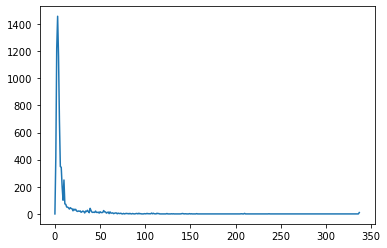

In [603]:
plt.plot(nx.degree_histogram(G))

## In-degree centrality

In [604]:
in_deg=nx.in_degree_centrality(G)

In [605]:
in_degTups=[(k,v) for k,v in in_deg.items()]
in_degDF=pd.DataFrame.from_records(in_degTups,columns=['author','in-degree'])

# Top 10 Authors by indegree
in_degDF.sort_values(by='in-degree',ascending=False).head(10)

,author,in-degree
141,Bengio Y.,0.015297
1019,Liu Z.,0.013301
100,De Raedt L.,0.010641
88,Cohen W.W.,0.009311
138,Wang L.,0.009178
81,Socher R.,0.009045
1507,Zhang Y.,0.008779
429,Riedel S.,0.008779
84,Zhu X.,0.008646
656,Zhang Z.,0.008646


In [618]:
list(nx.all_neighbors(G, 'Bengio  Y. '))

['Afsharchi  M.',
 'Bianchi  F.',
 'Chang  Y.-C.',
 'Chen  D.',
 'Condeço  J.',
 'Corchuelo  R.',
 'Csiszár  G.',
 'Cussens  J.',
 "D'Avila  Garcez  A.S.",
 'De  Raedt  L.',
 'Demeester  T.',
 'Dombi  J.',
 'Dumančić  S.',
 'Ebrahimi  M.',
 'Espinasse  B.',
 'Fdez-Riverola  F.',
 'Freitas  F.',
 'Garcez  A.A.',
 'Gentili  R.J.',
 'Gershman  S.J.',
 'Goodman  N.D.',
 'Gori  M.',
 'Guo  D.',
 'Han  L.',
 'Hohenecker  P.',
 'Jain  M.',
 'Johnson-Laird  P.N.',
 'Katz  G.E.',
 'Khorrami  F.',
 'Kimmig  A.',
 'Liang  C.',
 'Lin  C.-T.',
 'Lourenço  A.',
 'Lukasiewicz  T.',
 'Manrique  D.',
 'McDonough  J.',
 'Mirbakhsh  N.',
 'Nasraoui  O.',
 'Norman  T.J.',
 'Pandey  H.M.',
 'Parsons  S.',
 'Rabkina  I.',
 'Raj  B.',
 'Reggia  J.A.',
 'Riguzzi  F.',
 'Rosé  C.P.',
 'Roth  D.',
 'Saccà  C.',
 'Sammons  M.',
 'Sanders  S.',
 'Sarker  M.K.',
 'Sarmadi  A.',
 'Serrano  E.',
 'Shi  Y.',
 'Si  C.',
 'Silva  S.',
 'Soh  H.',
 'Stenning  K.',
 'Su  S.-F.',
 'Sun  L.',
 'Trujillo  L.',
 'Vittorini  

## PageRank centrality

In [611]:
pagerank=nx.pagerank(G)

In [612]:
pagerankTups=[(k,v) for k,v in pagerank.items()]

In [613]:
pagerankDF=pd.DataFrame.from_records(pagerankTups,columns=['author','pr'])

In [614]:
# Top 10 Authors
pagerankDF.sort_values(by='pr',ascending=False).head(10)

,author,pr
875,Chakraborty S.,0.001573
4605,Peng Y.I.,0.000744
605,Xiao F.,0.000537
2509,Mendes P.N.,0.000439
5108,Brun Y.,0.000436
4530,Socher R.,0.000434
141,Bengio Y.,0.000338
4639,Biswas A.,0.000335
1019,Liu Z.,0.000289
429,Riedel S.,0.000265


# Keyword analysis

In [5]:
pd.set_option('display.max_colwidth', None)
dfk=pd.read_csv("scopus (233).csv")

In [6]:
dfk=dfk[['Author Keywords','Index Keywords']]
dfk=dfk.dropna()

In [7]:
dfk=dfk.astype(str)
dfk['all_keywords']=dfk[['Author Keywords','Index Keywords']].agg(';'.join, axis=1)
dfk = dfk.reset_index()
dfk = dfk.set_index('index').reset_index()

In [8]:
dfk['all_keywords']=dfk['all_keywords'].str.split(pat=";")

In [9]:
dfk=dfk.set_index(['index']).apply(pd.Series.explode).reset_index()

In [10]:
dfk=dfk[['index','all_keywords']]

In [11]:
dfk=dfk.groupby('all_keywords').count().reset_index().sort_values(by='index', ascending=False)

In [12]:
# dfk=dfk[dfk['index']>15]

<BarContainer object of 30 artists>

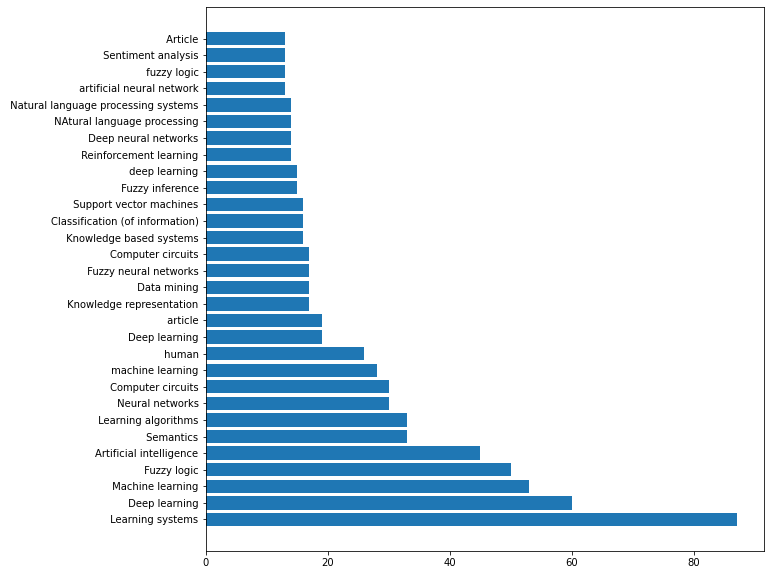

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(dfk['all_keywords'].head(30),dfk['index'].head(30))

## Keyword wordcloud

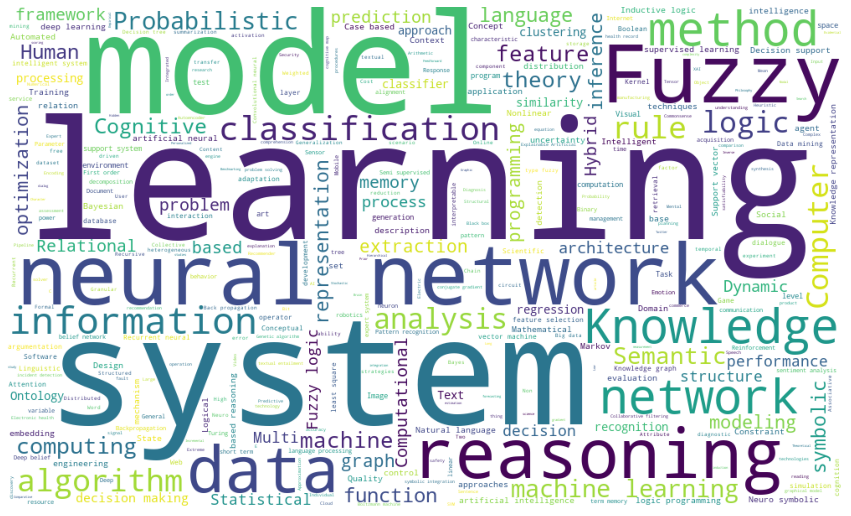

In [957]:
text = ','.join(list(dfk['all_keywords']))
drawCloud(text)

## Market-basket analysis on keywords
### Frequent itemsets

$$ Support=\frac{\#(X,Y)}{N} $$

$$ Confidence=\frac{\#(X,Y)}{\#(X)} $$

$$ Lift=\frac{Support}{Support(X)\times Support(Y)} $$

In [17]:
# !pip install mlxtend

In [14]:
pd.set_option('display.max_colwidth', None)
baskets=pd.read_csv("scopus (233).csv")

In [15]:
baskets=baskets[['Author Keywords','Index Keywords']]
baskets=baskets.dropna()

In [16]:
baskets=baskets.astype(str)
baskets['all_keywords']=baskets[['Author Keywords','Index Keywords']].agg(';'.join, axis=1)
baskets['Author Keywords']=baskets['Author Keywords'].map(lambda x: x.lower()).str.split(pat=";")
baskets['Index Keywords']=baskets['Index Keywords'].map(lambda x: x.lower()).str.split(pat=";")
baskets['all_keywords']=baskets['all_keywords'].map(lambda x: x.lower()).str.split(pat=";")

In [18]:
keywords='all_keywords'
dataset=baskets[keywords]

In [19]:
from mlxtend.frequent_patterns import fpgrowth,fpmax, apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
# http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
# df

In [20]:
# combination appears in <support> ratio of dataset, ie 0.05 means this combination of keywords appears in 5% of the dataset
support=0.05 
freq_items=fpgrowth(df, min_support=support, use_colnames=True)

In [21]:
for i in freq_items.sort_values(by='support',ascending=False)['itemsets']:
    print(i)

frozenset({' learning systems'})
frozenset({' machine learning'})
frozenset({' deep learning'})
frozenset({' fuzzy logic'})
frozenset({'artificial intelligence'})
frozenset({' semantics'})
frozenset({' learning algorithms'})
frozenset({' article'})
frozenset({' computer circuits'})
frozenset({' machine learning', ' learning systems'})
frozenset({'artificial intelligence', ' learning systems'})
frozenset({' neural networks'})
frozenset({' learning systems', ' fuzzy logic'})
frozenset({' human'})
frozenset({' natural language processing'})
frozenset({'deep learning'})
frozenset({' machine learning', ' learning algorithms'})
frozenset({' machine learning', ' fuzzy logic'})
frozenset({' learning algorithms', ' learning systems'})
frozenset({' article', ' human'})
frozenset({'computer circuits'})
frozenset({' semantics', ' learning systems'})
frozenset({' artificial intelligence'})
frozenset({' fuzzy neural networks'})
frozenset({' machine learning', ' article'})
frozenset({' knowledge base

In [22]:
rules = association_rules(freq_items, min_threshold=0.01)

In [29]:
rules.sort_values(by='support',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,( machine learning),( learning systems),0.338462,0.441026,0.153846,0.454545,1.030655,0.004576,1.024786
11,( learning systems),( machine learning),0.441026,0.338462,0.153846,0.348837,1.030655,0.004576,1.015934
53,( learning systems),(artificial intelligence),0.441026,0.210256,0.148718,0.337209,1.603800,0.055989,1.191543
52,(artificial intelligence),( learning systems),0.210256,0.441026,0.148718,0.707317,1.603800,0.055989,1.909829
69,( fuzzy logic),( learning systems),0.225641,0.441026,0.138462,0.613636,1.391385,0.038948,1.446757
...,...,...,...,...,...,...,...,...,...
64,( article),( deep learning),0.164103,0.271795,0.051282,0.312500,1.149764,0.006680,1.059207
65,( deep learning),( article),0.271795,0.164103,0.051282,0.188679,1.149764,0.006680,1.030292
66,( humans),( human),0.056410,0.133333,0.051282,0.909091,6.818182,0.043761,9.533333
67,( human),( humans),0.133333,0.056410,0.051282,0.384615,6.818182,0.043761,1.533333


## Association Rules heatmap

In [60]:
from collections import defaultdict
antecendents=rules['antecedents'].map(lambda x: ';'.join(list(x)).strip())
consequents=rules['consequents'].map(lambda x: ';'.join(list(x)).strip())
support=rules['support']

zipped=zip(antecendents,consequents,support)

d=defaultdict(dict)

for i in list(zipped):
    d[i[0]][i[1]]=i[2]

In [94]:
# for k, v in d.items():
#     print(k)
#     print(v)
#     print("-"*20)
#     for i,j in v.items():
#         print(i, j)
#     print("="*50)    

In [90]:
assd=pd.DataFrame(d)

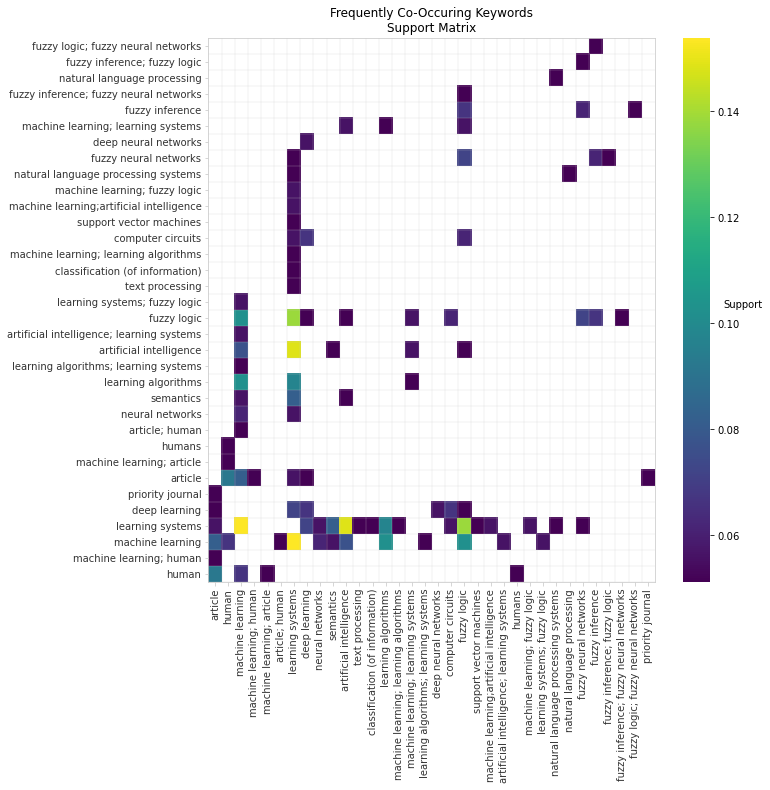

In [145]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.hlines(y=np.arange(0, len(assd.index), 1), xmin=np.full(len(assd.index),0), xmax=np.full(len(assd.index),len(assd.index)), color="#cccccc", linewidth=.25)
plt.vlines(x=np.arange(0, len(assd.columns), 1), ymin=np.full(len(assd.index),0), ymax=np.full(len(assd.index),len(assd.index)), color="#cccccc",linewidth=.25)
plt.yticks(np.arange(0.5, len(assd.index), 1), assd.index)
plt.xticks(np.arange(0.5, len(assd.columns), 1), assd.columns, rotation=90)
plt.title("Frequently Co-Occuring Keywords\nSupport Matrix")

graph=plt.pcolor(assd)
cb = fig.colorbar(graph)
cb.set_label('Support', rotation=0, va='bottom')
cb.outline.set_visible(False)

# Set the borders to a given color...
ax.tick_params(color='#cccccc', labelcolor='#333333')
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')

plt.show()

## Association Rules Scatterplot

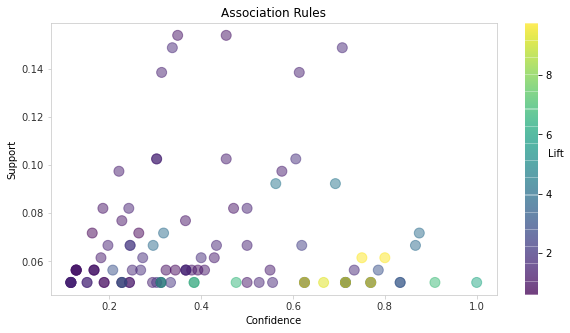

In [146]:
fig, ax = plt.subplots(figsize=(10, 5))
graph=plt.scatter(rules['confidence'],rules['support'],c=rules['lift'],s=100,alpha=0.5)
cb = fig.colorbar(graph)
cb.set_label('Lift', rotation=0, va='bottom')
cb.outline.set_visible(False)

# Set the borders to a given color...
ax.tick_params(color='#cccccc', labelcolor='#333333')
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')

plt.title('Association Rules')
plt.xlabel('Confidence')
plt.ylabel('Support')
plt.show()